<a href="https://colab.research.google.com/github/babar21/Deep_Learning_MVA/blob/master/nlp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [0]:
import io
import os
import numpy as np
import scipy
from operator import itemgetter

In [3]:
#PATH_TO_DATA = "/Users/bastien/Documents/ENS_2018-2019/Deep Learning/MP2/data/"

PATH_TO_DATA = "/content/gdrive/My Drive/Colab Notebooks/Deep MP2/"

from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1) Monolingual (English) word embeddings 

In [0]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        # brute force
        list_score = []
        for key, value in self.word2vec.items():
            if key == w :
                pass
            else :
                list_score.append((key, self.score(w,key)))    
        sorted_list_score = sorted(list_score,key=itemgetter(1))
        return [u[0] for u in sorted_list_score[-K:]]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        return np.dot(self.word2vec[w1], self.word2vec[w2])/(np.linalg.norm(self.word2vec[w1])*
                                                                             np.linalg.norm(self.word2vec[w2]))


In [5]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=55000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w1,w2v.most_similar(w1))

Loaded 55000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
cat ['kitties', 'feline', 'kitten', 'kitty', 'cats']
dog ['canine', 'doggie', 'Dog', 'puppy', 'dogs']
dogs ['puppies', 'canines', 'doggies', 'Dogs', 'dog']
paris ['europe', 'berlin', 'london', 'Paris', 'france']
germany ['italy', 'france', 'berlin', 'german', 'europe']


In [0]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        for sent in sentences:
            if idf is False:
                # mean of word vectors
                all_words = [self.w2v.word2vec.get(word) for word in sent.split()]
                all_words = list(filter(None.__ne__, all_words))
                if all_words:
                    sentemb.append(np.array(all_words).mean(axis=0))
            else:
                # idf-weighted mean of word vectors
                all_weight=[]
                all_words=[]
                for word in sent.split():
                    if (self.w2v.word2vec.get(word) is None) or (idf.get(word) is None):
                        pass
                    else:
                        all_words.append(self.w2v.word2vec[word]*idf[word])
                        all_weight.append(idf[word])
                if all_words:
                    sentemb.append(np.array(all_words).sum(axis=0)/np.sum(all_weight))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        l_dist = []
        for i in range(np.shape(keys)[0]):
            l_dist.append(self.score(query[0],keys[i,:],idf))
        sorted_dist_idx = np.argsort(l_dist)
        print('original sentence : {}'.format(s))
        for a in sorted_dist_idx[-K:]:
            print('  {}'.format(sentences[a]))
        return

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        if type(s1) == str :
            s1 = self.encode([s1],idf)[0]
        if type(s2) == str :
            s2 = self.encode([s2],idf)[0]    
        return np.dot(s1, s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
             for w in sent.split():
                idf[w] = idf.get(w, 0) + 1
        tf = {}
        for word, count in idf.items():
            tf[word] = max(1, np.log10(len(sentences) / count))
        return tf

In [9]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
# used very simple tokenization, using only spaces to delimit words with .split() function
sentences = [line.rstrip('\n') for line in open(os.path.join(PATH_TO_DATA, 'sentences.txt'))]

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
s = s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13])
print(s)

 
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
s = s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf)
print(s)

Loaded 200000 pretrained word vectors
original sentence : 1 smiling african american boy . 
  an african american man is sitting . 
  an afican american woman standing behind two small african american children . 
  a little african american boy and girl looking up . 
  an african american man smiling . 
  1 smiling african american boy . 
0.5726258859719605
original sentence : 1 smiling african american boy . 
  an afican american woman standing behind two small african american children . 
  a little african american boy and girl looking up . 
  an african american man is sitting . 
  an african american man smiling . 
  1 smiling african american boy . 
0.4750927980105363


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [0]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)


Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [0]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
def identic_word(dict1,dict2):
    l_word1 = set(dict1.word2vec.keys())
    l_word2 = dict2.word2vec.keys()
    return [word for word in l_word2 if word in l_word1]
    
def create_matrix(dict_world, list_words):
    X = []
    for word in list_words:
        X.append(dict_world.word2vec[word])
    return np.array(X).T

list_words = identic_word(w2v_en, w2v_fr)
X_fr = create_matrix(w2v_fr, list_words)
Y_en = create_matrix(w2v_en, list_words)


In [0]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

import scipy.linalg as spl

# TYPE CODE HERE
def find_mapping(X,Y):
    U,s,Vh = spl.svd(np.dot(Y,X.T))
    return np.dot(U,Vh)

W = find_mapping(X_fr,Y_en)


In [0]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

# French to English 
print('French -> English :')
for w1 in ['jeu', 'village', 'guerre', 'chat', 'chien']:
    embd_en = np.dot(W,w2v_fr.word2vec[w1])
    w2v_en.word2vec['added_french_word'] = embd_en
    print(w1,w2v_en.most_similar('added_french_word'))
    
# English to French
print('English -> French :')
for w1 in ['asparagus', 'city', 'war', 'tiger', 'poodle']:
    embd_en = np.dot(W.T,w2v_en.word2vec[w1])
    w2v_fr.word2vec['added_english_word'] = embd_en
    print(w1,w2v_fr.most_similar('added_english_word'))

French -> English
jeu ['multiplayer', 'dreamcast', 'videogame', 'game', 'gameplay']
village ['wielkie', 'kolonia', 'wieś', 'villages', 'village']
guerre ['wwi', 'guerre', 'wars', 'hostilities', 'war']
chat ['poodle', 'feline', 'hamster', 'rabbit', 'cat']
chien ['spaniel', 'dogs', 'terrier', 'poodle', 'dog']
English -> French
asparagus ['légumes', 'légume', 'ananas', 'haricots', 'légumineuses']
city ['villes', 'cities', 'town', 'ville', 'city']
war ['military', 'guerres', 'mondialeseconde', 'war', 'guerre']
tiger ['bison', 'panther', 'tigre', 'tigres', 'tiger']
poodle ['lapin', 'hound', 'chatte', 'chienne', 'chien']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [0]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
def load_set(name):
    if name == 'stsa.fine.test.X':
        return [line.rstrip('\n') for line in open(os.path.join(PATH_TO_DATA, name))]
    else : 
        s = [line.rstrip('\n') for line in open(os.path.join(PATH_TO_DATA, name))]
        label = np.array([int(sentence[0]) for sentence in s])
        sent = [sentence[2:] for sentence in s]
        return sent, label

sent_train, Y_train = load_set('stsa.fine.train')
sent_dev, Y_dev = load_set('stsa.fine.dev')
sent_test = load_set('stsa.fine.test.X')
    

In [0]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
X_train_1 = s2v.encode(sent_train)
X_dev_1 = s2v.encode(sent_dev)

idf = s2v.build_idf(sent_train)
X_train_2 = s2v.encode(sent_train, idf)
X_dev_2 = s2v.encode(sent_dev, idf)


In [12]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

import sklearn.linear_model as skl
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

%matplotlib inline  

# TYPE CODE HERE
def tune_model(X_train, Y_train, X_dev, Y_dev):
    list_C = np.logspace(-2, 1, num=100)
    list_acc_dev = []
    list_acc_train = []
    list_loss_dev = []
    list_loss_train = []
    for C in list_C:
        # definition of the classifier and fit on the training set 
        classifier = skl.LogisticRegression(random_state=0, solver='saga',
                                multi_class='multinomial', penalty='l2', C=C, max_iter=10000).fit(X_train, Y_train)
        list_acc_dev.append(classifier.score(X_dev, Y_dev))
        list_acc_train.append(classifier.score(X_train, Y_train))
        y_pred_dev = classifier.predict_proba(X_dev)
        y_pred_train = classifier.predict_proba(X_train)
        list_loss_dev.append(log_loss(Y_dev, y_pred_dev))
        list_loss_train.append(log_loss(Y_train, y_pred_train))
    return list_C, list_acc_dev, list_acc_train, list_loss_dev, list_loss_train


def plot_tunning(list_C, list_acc_dev, list_acc_train, list_loss_dev, list_loss_train, logscale=True):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(list_C, list_acc_dev, label='dev_set')
    plt.plot(list_C, list_acc_train, label='train_set')
    if logscale : 
        plt.xscale('log')
    plt.title('Classifier Mean accuracy')
    plt.ylabel('Mean accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(list_C, list_loss_dev, label='dev_set')
    plt.plot(list_C, list_loss_train, label='train_set')
    if logscale : 
        plt.xscale('log')
    plt.title('Classifier Loss')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return

# BoV-mean
list_C, list_acc_dev_1, list_acc_train_1, list_loss_dev_1, list_loss_train_1 = tune_model(X_train_1, Y_train, 
                                                                                             X_dev_1, Y_dev)
# BoV-idf
list_C, list_acc_dev_2, list_acc_train_2, list_loss_dev_2, list_loss_train_2 = tune_model(X_train_2, Y_train, 
                                                                                              X_dev_2, Y_dev)

plot_tunning(list_C, list_acc_dev_1, list_acc_train_1, list_loss_dev_1, list_loss_train_1)
plot_tunning(list_C, list_acc_dev_2, list_acc_train_2, list_loss_dev_2, list_loss_train_2)


opt_C_mean = list_C[np.argmin(list_loss_dev_1)]
print('opt C BoV mean is : {}'.format(opt_C_mean))
print('Loss on train set is : {}'.format(np.min(list_loss_train_1)))
print('Loss on dev set is : {}'.format(np.min(list_loss_dev_1)))

opt_C_idf = list_C[np.argmin(list_loss_dev_2)]
print('opt C BoV idf is : {}'.format(opt_C_mean))
print('Loss on train set is : {}'.format(np.min(list_loss_train_2)))
print('Loss on dev set is : {}'.format(np.min(list_loss_dev_2)))

KeyboardInterrupt: ignored

In [0]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
# For C = 0.76 (fine tuning on the dev set) - choosed BoV-mean 
X_test = s2v.encode(sent_test)
C = 0.756
best_class_classifier = skl.LogisticRegression(random_state=0, solver='saga',
                                multi_class='multinomial', penalty='l2', C=C, max_iter=10000).fit(X_train_1, Y_train)

Y_test_pred = list(best_class_classifier.predict(X_test))

# writing text file
with open('logreg_bov_y_test_sst.txt', 'w') as f:
    for item in Y_test_pred:
        f.write("%s\n" % item)

        

In [0]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [1]:
import keras
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "/content/gdrive/My Drive/Colab Notebooks/Deep MP2/"

# To be used on gg colab
def load_set_gg_colab(name):
    if name == 'stsa.fine.test.X':
        return [line.rstrip('\n') for line in open(os.path.join(PATH_TO_DATA, name))]
    else : 
        s = [line.rstrip('\n') for line in open(os.path.join(PATH_TO_DATA, name))]
        label = np.array([int(sentence[0]) for sentence in s])
        sent = [sentence[2:] for sentence in s]
        return sent, label


# TYPE CODE HERE
sent_train, Y_train = load_set_gg_colab('stsa.fine.train')
Y_train = to_categorical(Y_train)
sent_dev, Y_dev = load_set_gg_colab('stsa.fine.dev')
Y_dev = to_categorical(Y_dev)
sent_test = load_set_gg_colab('stsa.fine.test.X')

In [0]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/


# TYPE CODE HERE

def process_sentence(sentence_list, vocab_size):
    return [keras.preprocessing.text.one_hot(sentence, vocab_size) for sentence in sentence_list]

vocab_size = 5000
encode_train = process_sentence(sent_train, vocab_size)
encode_dev = process_sentence(sent_dev, vocab_size)
encode_test = process_sentence(sent_test, vocab_size)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [0]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

from keras.preprocessing.sequence import pad_sequences

# TYPE CODE HERE
X_train = pad_sequences(encode_train)
X_dev = pad_sequences(encode_dev)
X_test =pad_sequences(encode_test)

## 4.2 - Design and train your model

In [0]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Activation
from keras.regularizers import l2, l1

embed_dim  = 32  # word embedding dimension
nhid       = 128 # number of hidden units in the LSTM
vocab_size = 5000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1)))
model.add(Dense(n_classes, activation='softmax'))


In [25]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
from keras import optimizers


loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  optimizers.Adam(lr=0.001) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 243,077
Trainable params: 243,077
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
import matplotlib.pyplot as plt

%matplotlib inline  

def plot_tunning(history, name):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'][1:], label='train_set')
    plt.plot(history.history['val_acc'][1:], label='dev_set')
    plt.title('{} Classifier Accuracy'.format(name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'][1:], label='train_set')
    plt.plot(history.history['val_loss'][1:], label='dev_set')
    plt.title('{} Classifier Loss'.format(name))
    plt.ylabel('Cross-Entropy Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return


bs = 32
n_epochs = 6

history = model.fit(X_train, Y_train, batch_size=bs, epochs=n_epochs, validation_data=(X_dev, Y_dev))

plot_tunning(history, 'LSTM')

Train on 8544 samples, validate on 1101 samples
Epoch 1/6
8544/8544 [==============================] - 34s 4ms/step - loss: 3.5718 - acc: 0.2659 - val_loss: 1.5747 - val_acc: 0.2534
Epoch 2/6
8544/8544 [==============================] - 32s 4ms/step - loss: 1.5704 - acc: 0.2679 - val_loss: 1.5796 - val_acc: 0.2534
Epoch 3/6
8544/8544 [==============================] - 31s 4ms/step - loss: 1.5699 - acc: 0.2724 - val_loss: 1.5731 - val_acc: 0.2525
Epoch 4/6
8544/8544 [==============================] - 31s 4ms/step - loss: 1.5569 - acc: 0.3274 - val_loss: 1.5277 - val_acc: 0.3488
Epoch 5/6
8544/8544 [==============================] - 32s 4ms/step - loss: 1.4430 - acc: 0.4033 - val_loss: 1.4912 - val_acc: 0.3715
Epoch 6/6
8544/8544 [==============================] - 31s 4ms/step - loss: 1.3446 - acc: 0.4396 - val_loss: 1.4873 - val_acc: 0.3642


In [0]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

# test set predictions
predicted_labels = np.argmax(model.predict(X_test), axis=-1)

# saving in the output file
with open('logreg_lstm_y_test_sst.txt', 'w') as f:
    for item in predicted_labels:
        f.write("%s\n" % item)

files.download('logreg_lstm_y_test_sst.txt')

## 4.3 -- innovate !

Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 6s 754us/step - loss: 2.7937 - acc: 0.2763 - val_loss: 2.2494 - val_acc: 0.3769
Epoch 2/10
8544/8544 [==============================] - 2s 186us/step - loss: 2.0712 - acc: 0.3668 - val_loss: 1.8413 - val_acc: 0.3942
Epoch 3/10
8544/8544 [==============================] - 2s 186us/step - loss: 1.7060 - acc: 0.4154 - val_loss: 1.6274 - val_acc: 0.3924
Epoch 4/10
8544/8544 [==============================] - 2s 188us/step - loss: 1.5110 - acc: 0.4464 - val_loss: 1.5172 - val_acc: 0.3996
Epoch 5/10
8544/8544 [==============================] - 2s 187us/step - loss: 1.3806 - acc: 0.4695 - val_loss: 1.4399 - val_acc: 0.4242
Epoch 6/10
8544/8544 [==============================] - 2s 184us/step - loss: 1.2912 - acc: 0.5042 - val_loss: 1.4374 - val_acc: 0.4105
Epoch 7/10
8544/8544 [==============================] - 2s 186us/step - loss: 1.2458 - acc: 0.5167 - val_loss: 1.4114 - val_acc: 0.4169


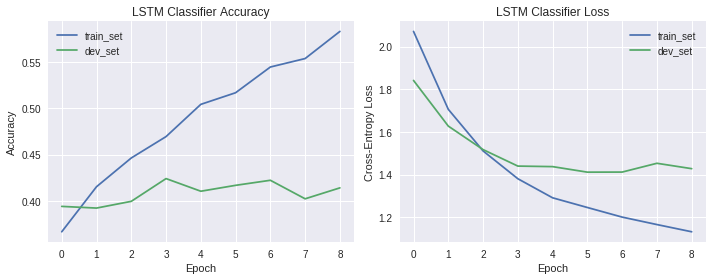

In [116]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D, concatenate, Dropout

import numpy as np
np.random.seed(1337) # for reproducibility

MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 1

# word embedding (used glove instead of provided word2vec since there were less missing words in glove when
# when reading the sets - 347 missing words vs 1779 missing words)
embeddings_index = {}
with open(os.path.join(PATH_TO_DATA, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(sent_train)
sequences_train = tokenizer.texts_to_sequences(sent_train)
sequences_dev = tokenizer.texts_to_sequences(sent_dev)
sequences_test = tokenizer.texts_to_sequences(sent_test)



# find longest sequence amongst all sets to pad sentences
for sequences in [sequences_train,sequences_dev, sequences_test]:
  for l in sequences : 
    if len(l)>MAX_SEQUENCE_LENGTH:
        MAX_SEQUENCE_LENGTH = len(l)
        
x_train = pad_sequences(sequences_train, MAX_SEQUENCE_LENGTH)
x_dev = pad_sequences(sequences_dev, MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, MAX_SEQUENCE_LENGTH)

# pretrained embedding
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
# building network
nb_filter = 50
filter_lengths = [1,2,3]
hidden_dims = 128

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


words_convolutions = []
for filter_length in filter_lengths:
    words_conv = Conv1D(filters=nb_filter,
                            kernel_size=filter_length,
                            padding='same',
                            activation='relu',
                            strides=1)(embedded_sequences)
                            
    words_conv = GlobalMaxPooling1D()(words_conv)      
    
    words_convolutions.append(words_conv)  

output = concatenate(words_convolutions)



# We add a vanilla hidden layer together with dropout layers:
output = Dropout(0.5)(output)
output = Dense(hidden_dims, activation='tanh', kernel_regularizer=l2(0.01))(output)
output = Dropout(0.25)(output)


# We project onto a single unit output layer, and squash it with a sigmoid:
output = Dense(n_classes, activation='softmax',  kernel_regularizer=l2(0.01))(output)

model = Model(inputs=[sequence_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# optim parameters
bs = 64
n_epochs = 10

# training
hist = model.fit(x_train, Y_train, validation_data=(x_dev, Y_dev),
                 epochs=n_epochs, batch_size=bs)

# plot learning
plot_tunning(hist)

# test set predictions
predicted_labels = np.argmax(model.predict(X_test), axis=-1)

# saving in the output file
with open('XXX_XXX_y_test_sst.txt', 'w') as f:
    for item in predicted_labels:
        f.write("%s\n" % item)

files.download('XXX_XXX_y_test_sst.txt')


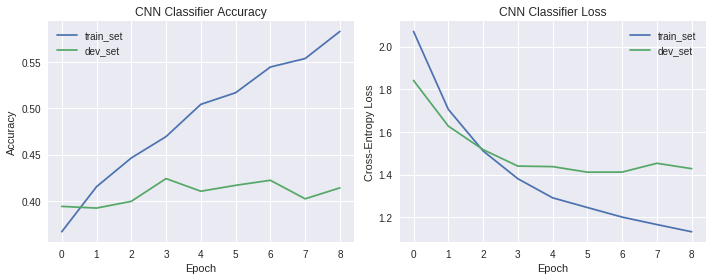

In [119]:
plot_tunning(hist, 'CNN')

